<b>Name : Tejas Karimanne Indushekar</b><br/>

In [1]:
import requests
import json
import csv
import datetime
import pandas as pd
from sklearn import preprocessing

### Task 1 - Identifying API

The Api being used is selected from the website https://rapidapi.com/<br/>
API link : https://rapidapi.com/weatherbit/api/air-quality <br/>
For the assignment am making use of the Air quality API, which provides hostorical data for the last 24 hours and also the forecast data for the next 3 days.<br/>
Two end point have been used, one for historical data and one for forecast.<br/>
API key is provided once we register in the 'rapidapi' webiste.<br/>

### Task 2 - Collecting data from the API

Data has been collected over a period of few days for better analysis since only imited data was available everyday. <br/>
Below are few functions that will be used througout the assignment

In [2]:
#create a file with set headings - 2 diff types of data to store
def create_file (file_name, col_featur_names): 
    with open(file_name, "w",newline='') as write_file: #as in get_and_write_data function 
        f = csv.writer(write_file)
        f.writerow(col_featur_names)
    write_file.close()

    # Parsing the json format data recieved from the api to store it to a csv.
def fetchApiData(response,county_name):
    dataFrameRawData = pd.read_csv("air_pollution_raw_data.csv")
    dataFrameRawData = dataFrameRawData.loc[dataFrameRawData.county_name==county_name]
    
    str1 = ""
    listToString = str1.join(dataFrameRawData.datetime)
    
    with open("air_pollution_raw_data.csv", "a",newline='') as outputFile:
        f = csv.writer(outputFile,delimiter=',')
        json_data = json.loads(response.text)
        for data in json_data['data']:
            if listToString.find(str(data['datetime']))>=0:
                continue

            row = raw_row(data)
            # Data present in the outer node of json respose from api
            row.append(json_data['city_name'])
            row.append(json_data['lat'])
            row.append(json_data['lon'])
            row.append(json_data['timezone'])
            row.append(json_data['country_code'])
            row.append(json_data['state_code'])
            row.append(county_name)
            f.writerow(row)
    outputFile.close()

# Data present in the inner node of json response from api
def raw_row(data):
    row = []
    row.append(data['aqi'])
    row.append(data['o3'])
    row.append(data['so2'])
    row.append(data['no2'])
    row.append(data['co'])
    row.append(data['pm25'])
    row.append(data['pm10'])
    row.append(data['timestamp_local'])
    row.append(data['timestamp_utc'])
    row.append(data['datetime'])
    row.append(data['ts'])
    return row

Below code is commented so that the existing data collected over a period of time does not get overwritten with limited amount of data from the API

In [3]:
# Creating a new csv to capture the raw data from the API with apporpriate columns
# row_data_headings = ['aqi','o3','so2','no2','co','pm25','pm10','timestamp_local','timestamp_utc','datetime','ts',\
#                      'city_name','lat','lon','timezone','country_code','state_code','county_name']
# create_file("air_pollution_raw_data.csv",row_data_headings)

For the assignment air quality data of 10 counties in Ireland has been considered.

In [4]:
county_lat_long_dict = {
  "Dublin": {"lat":"53.3498","lon":"6.2603"},
  "Carlow": {"lat":"52.8365","lon":"6.9341"},
  "wicklow": {"lat":"52.9808","lon":"6.0446"},
  "Kildare": {"lat":"53.1589","lon":"6.9096"},
  "Galway": {"lat":"53.2707","lon":"9.0568"},
  "Cork": {"lat":"51.8985","lon":"8.4756"},
  "Limerick": {"lat":"52.6638","lon":"8.6267"},
  "Wexford": {"lat":"52.3369","lon":"6.4633"},
  "Kilkenny": {"lat":"52.6541","lon":"7.2448"},
  "Waterford": {"lat":"52.2593","lon":"7.1101"}
}

### Task 3 - Invoke API and store the data in appropriate format (csv)

API provides three endpoints of which 2 endpoints are used. <br/>
Header along with two parameters (lat and long) and URL is required to invoke the API.<br/>
Response from both the endpoints have been stored in the same file.

API Call for the first endpoint which provides historical data

In [1]:
url = "https://air-quality.p.rapidapi.com/history/airquality"

headers = {
    'x-rapidapi-host': "air-quality.p.rapidapi.com",
    'x-rapidapi-key': "Insert API Key here"
    }

In [6]:
for key in county_lat_long_dict.keys():
    querystring = {"lon":county_lat_long_dict[key]['lon'],"lat":county_lat_long_dict[key]['lat']}
    response = requests.request("GET", url, headers=headers, params=querystring)
    fetchApiData(response,key)

API call for the second endpoint which provides forecast data

In [7]:
forecastAirQualityUrl = "https://air-quality.p.rapidapi.com/forecast/airquality"
headers = {
    'x-rapidapi-host': "air-quality.p.rapidapi.com",
    'x-rapidapi-key': "46479bcfa9msh16d55e82923a74bp138494jsnda4f89093af9"
    }

In [8]:
for key in county_lat_long_dict.keys():
    querystring = {"lon":county_lat_long_dict[key]['lon'],"lat":county_lat_long_dict[key]['lat'],"hours":"100"}
    response = requests.request("GET", forecastAirQualityUrl, headers=headers, params=querystring)
    fetchApiData(response,key)

### Task 4 : Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data

In [9]:
req_data = pd.read_csv("air_pollution_raw_data.csv")
req_data = req_data[["aqi","o3","so2","no2","co","pm25","pm10","datetime","county_name","timestamp_utc"]] #removing unwanted columns

In [10]:
req_data['timestamp_utc'] = pd.to_datetime(req_data['timestamp_utc'])
req_data['just_date'] = req_data['timestamp_utc'].dt.date

Data for the column 'co' had very high values compared to rest of the columns, hence i have normalised the data using Min-Max normalisation for better analysis and visualisation.

In [11]:
x = req_data[["aqi","o3","so2","no2","co","pm25","pm10"]].values #returns a numpy array
min_max_data = preprocessing.MinMaxScaler() 
x_scaled = min_max_data.fit_transform(x) 
norm_data = pd.DataFrame(x_scaled)

In [12]:
req_data['aqi'] = norm_data[0]
req_data['o3'] = norm_data[1]
req_data['so2'] = norm_data[2]
req_data['no2'] = norm_data[3]
req_data['co'] = norm_data[4]
req_data['pm25'] = norm_data[5]
req_data['pm10'] = norm_data[6]

In [13]:
req_data.shape

(2400, 11)

Checking for the descriptive data statistics and for any null values present in the data to see if further pre processing or cleaning is required.

In [14]:
req_data.isnull().sum()

aqi              0
o3               0
so2              0
no2              0
co               0
pm25             0
pm10             0
datetime         0
county_name      0
timestamp_utc    0
just_date        0
dtype: int64

In [15]:
req_data.dtypes.value_counts()

float64           7
object            3
datetime64[ns]    1
dtype: int64

In [16]:
req_data.describe()

,aqi,o3,so2,no2,co,pm25,pm10
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.298881,0.593202,0.223629,0.190987,0.493812,0.223869,0.203572
std,0.201523,0.167239,0.197570,0.122265,0.181650,0.211716,0.172863
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.473449,0.080812,0.099959,0.356882,0.078905,0.079097
50%,0.261006,0.579952,0.151878,0.179560,0.513008,0.148076,0.157822
75%,0.323899,0.729117,0.313705,0.254885,0.628257,0.286865,0.256155
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Task 5 : Analysis, Visualisation and Summarisation of the data set

Creating a new data frame and grouping by count_name to check for Air Quality Index(aqi) with respect to all the counties

In [17]:
aqi_county = req_data[["aqi","county_name"]]

In [18]:
aqi_cou = aqi_county.groupby('county_name').mean()

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'County')

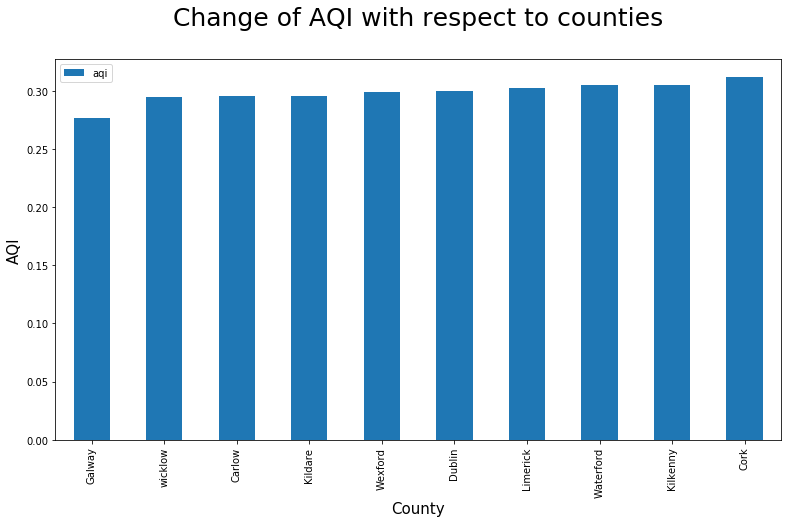

In [20]:
aqi_cou = aqi_cou.sort_values('aqi')
aqi_cou.plot(kind='bar',figsize=(13,7))
plt.title("Change of AQI with respect to counties\n", fontsize=25)
plt.ylabel("AQI", fontsize=15)
plt.xlabel("County", fontsize=15)

<i>From the above representation we can see Dublin has the highest AQI and Galway has the least AQI.<i/><br/>

Creating a new data frame and grouping by timestamp to check for Air Quality Index(aqi) 

In [21]:
aqi_time = req_data[["aqi","timestamp_utc","just_date"]]

In [22]:
aqi_time = aqi_time.set_index('timestamp_utc').groupby(pd.Grouper(freq='D')).mean() 

Text(0.5, 0, 'Date')

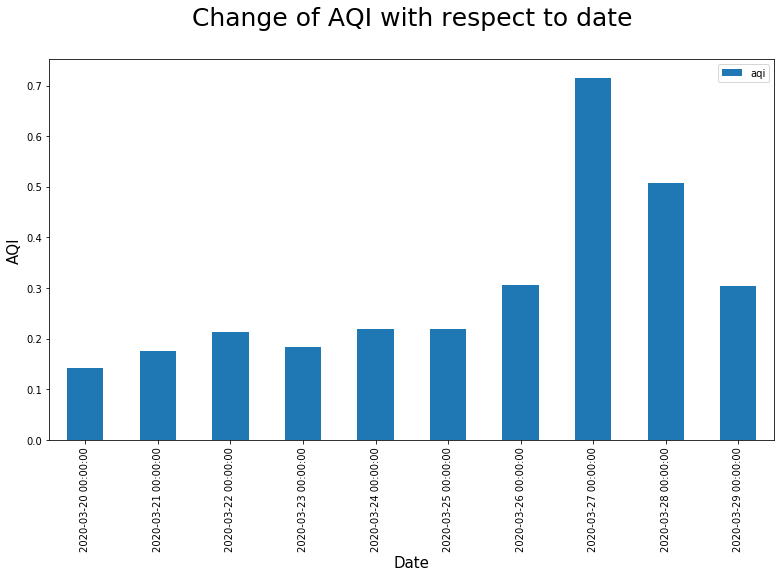

In [23]:
aqi_time.plot(kind='bar',figsize=(13,7))
plt.title("Change of AQI with respect to date\n", fontsize=25)
plt.ylabel("AQI", fontsize=15)
plt.xlabel("Date", fontsize=15)

<i> From the above we can see that 27th March 2020 had the highest AQI <i/>

<b>Analysis of features that effect AQI<b/><br/>

Description of features that effect the Air Quality Index<br/>
o3: Concentration of surface O3 (µg/m³)<br/>
so2: Concentration of surface SO2 (µg/m³)<br/>
no2: Concentration of surface NO2 (µg/m³)<br/>
co: Concentration of carbon monoxide (µg/m³)<br/>
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)<br/>
pm10: Concentration of particulate matter < 10 microns (µg/m³)<br/>

Text(0.5, 0, 'Date')

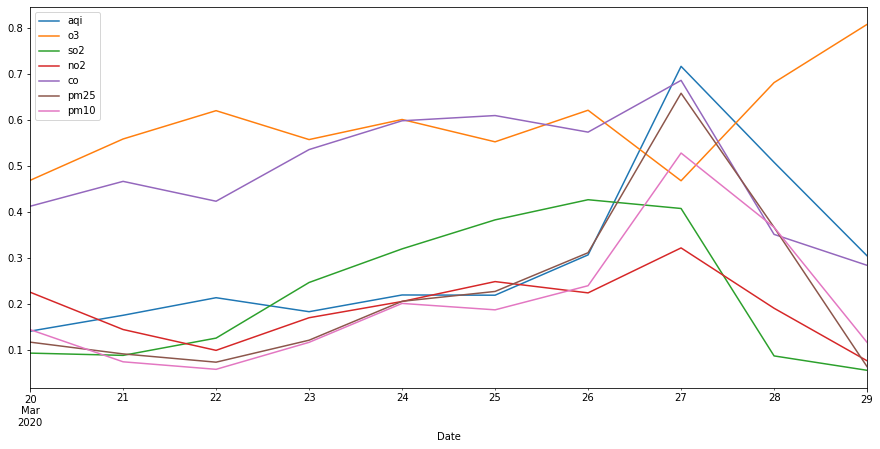

In [24]:
req_data['timestamp_utc'] = pd.to_datetime(req_data['timestamp_utc'])
req_data['just_date'] = req_data['timestamp_utc'].dt.date 
avg_date = req_data.set_index('timestamp_utc').groupby(pd.Grouper(freq='D')).mean() 
#print(avg_date[0:5]) 
avg_date = avg_date[['aqi','o3','so2','no2','co','pm25','pm10']] 
avg_date.plot(figsize=(15,7))
plt.xlabel("Date")

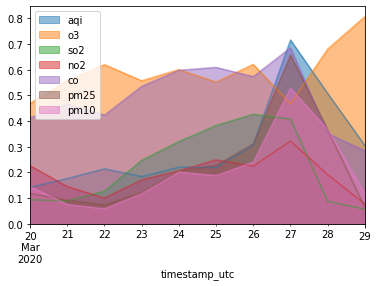

In [25]:
avg_date.plot.area(stacked=False)

Text(0.5, 0, 'Date')

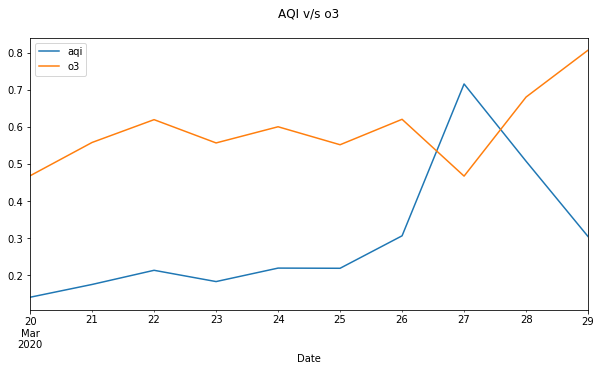

In [26]:
aqi_o3 = avg_date[["aqi","o3"]]
aqi_o3.plot(figsize=(10,5))
plt.title("AQI v/s o3\n")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

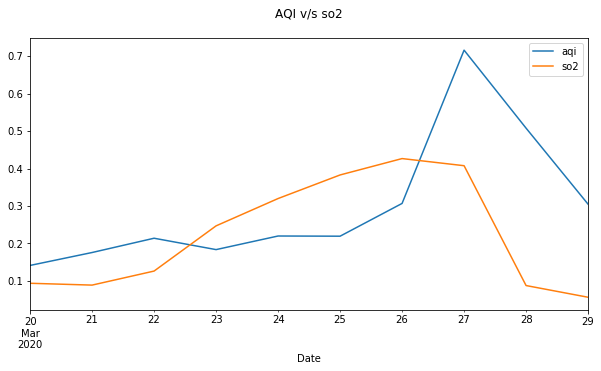

In [27]:
aqi_so2 = avg_date[["aqi","so2"]]
aqi_so2.plot(figsize=(10,5))
plt.title("AQI v/s so2\n")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

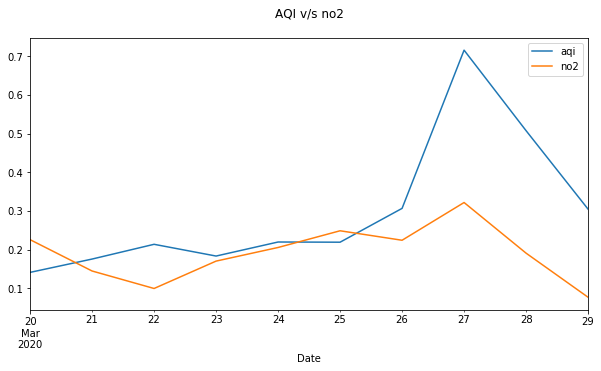

In [28]:
aqi_no2 = avg_date[["aqi","no2"]]
aqi_no2.plot(figsize=(10,5))
plt.title("AQI v/s no2\n")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

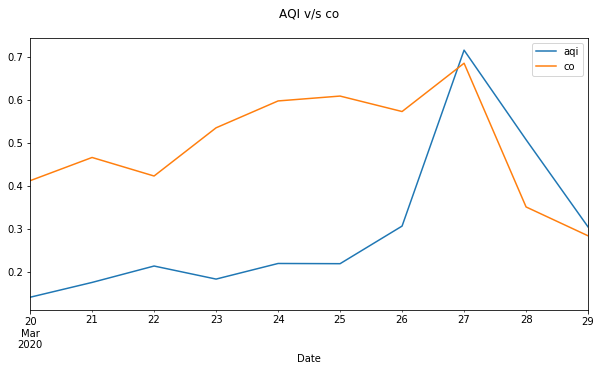

In [29]:
aqi_co = avg_date[["aqi","co"]]
aqi_co.plot(figsize=(10,5))
plt.title("AQI v/s co\n")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

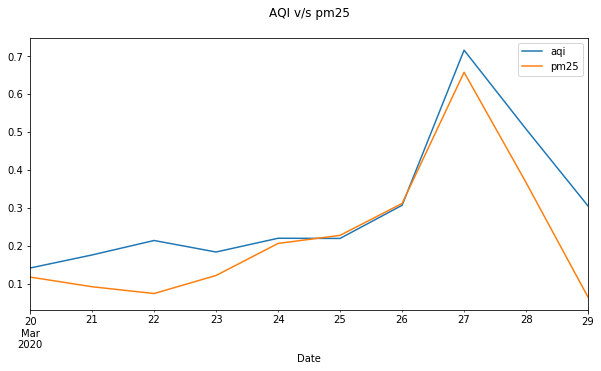

In [30]:
aqi_pm25 = avg_date[["aqi","pm25"]]
aqi_pm25.plot(figsize=(10,5))
plt.title("AQI v/s pm25\n")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

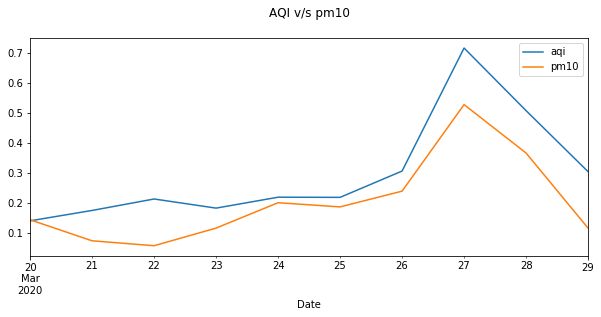

In [31]:
aqi_pm10 = avg_date[["aqi","pm10"]]
aqi_pm10.plot(figsize=(10,4))
plt.title("AQI v/s pm10\n")
plt.xlabel("Date")

<i>From all the above visualisations, we can see that 'pm25' and 'pm10' strongly affects the Air Quality Index(AQI)<i/>

<Figure size 432x288 with 0 Axes>

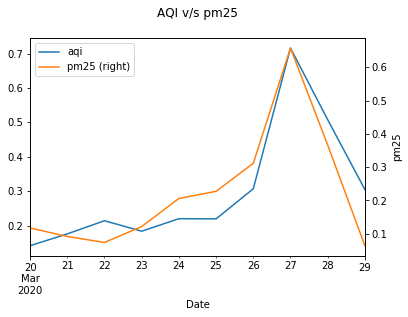

In [32]:
plt.figure()
ax = aqi_pm25.plot(secondary_y=['pm25'])
ax.set_xlabel("AQI")
ax.set_xlabel("Date")
ax.right_ax.set_ylabel("pm25")
plt.title("AQI v/s pm25\n")
plt.show()

<Figure size 432x288 with 0 Axes>

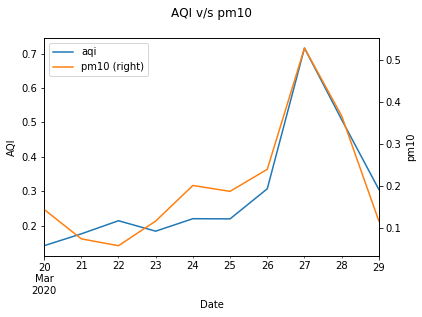

In [33]:
plt.figure()
ax = aqi_pm10.plot(secondary_y=['pm10'])
ax.set_ylabel("AQI")
ax.set_xlabel("Date")
ax.right_ax.set_ylabel("pm10")
plt.title("AQI v/s pm10\n")
plt.show()

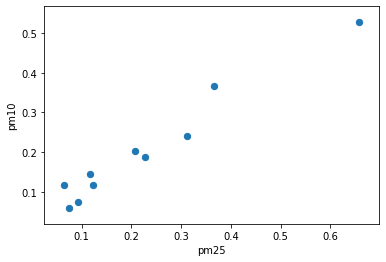

In [34]:
pm25_10 = avg_date[['pm25','pm10']] 
pm25_10.plot.scatter(x="pm25", y="pm10", s=40 )

Visualisation for AQI v/s pm25 v/s pm10 for each of the counties

<Figure size 720x504 with 0 Axes>

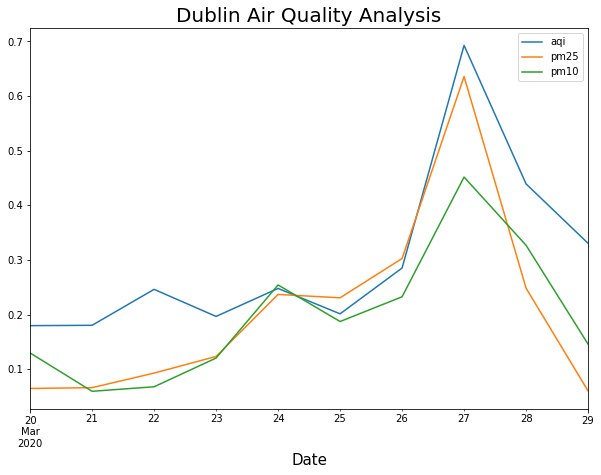

<Figure size 720x504 with 0 Axes>

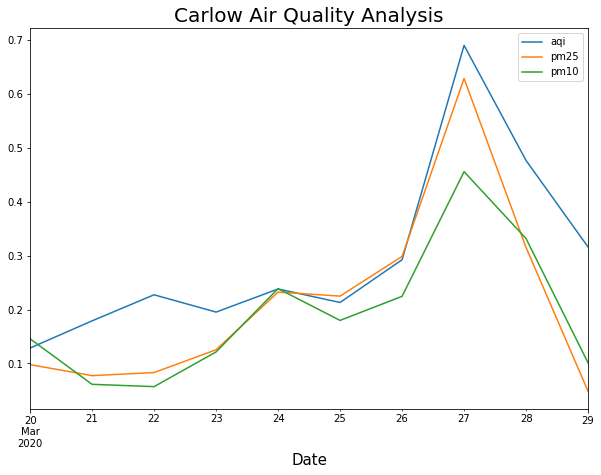

<Figure size 720x504 with 0 Axes>

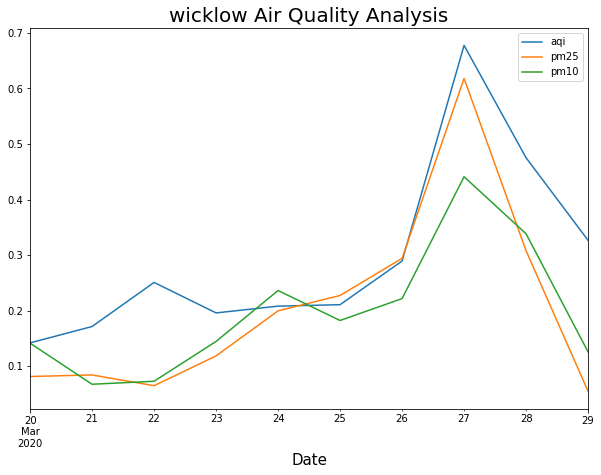

<Figure size 720x504 with 0 Axes>

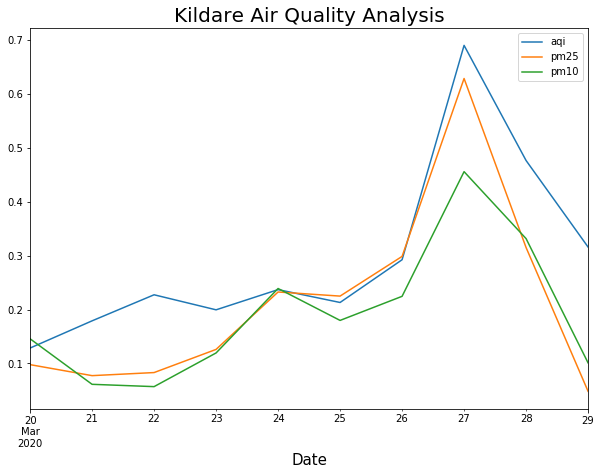

<Figure size 720x504 with 0 Axes>

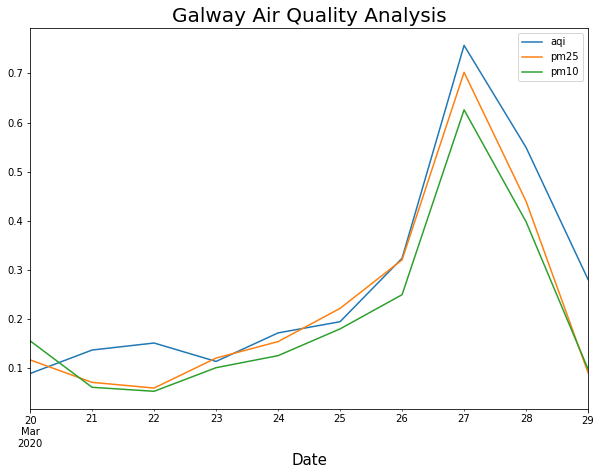

<Figure size 720x504 with 0 Axes>

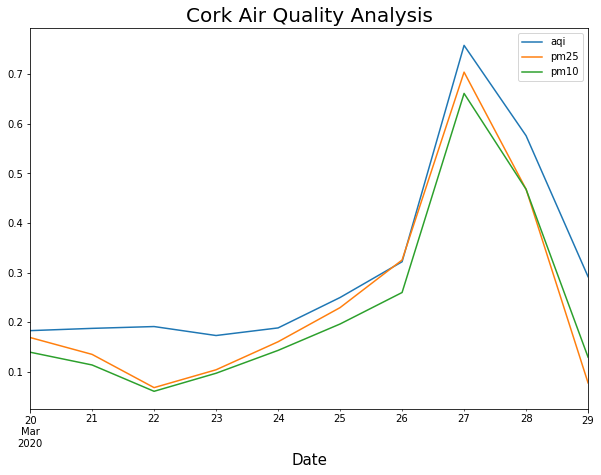

<Figure size 720x504 with 0 Axes>

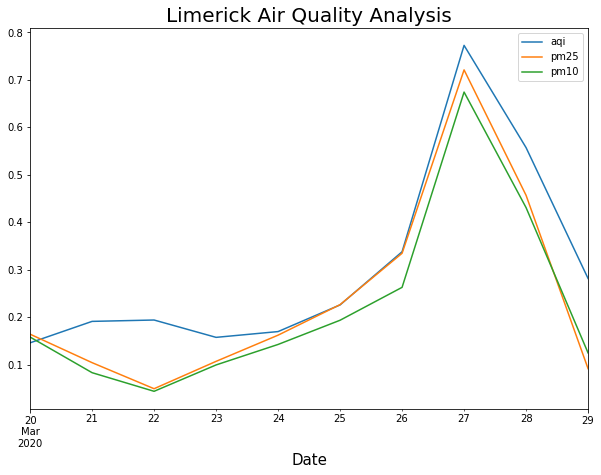

<Figure size 720x504 with 0 Axes>

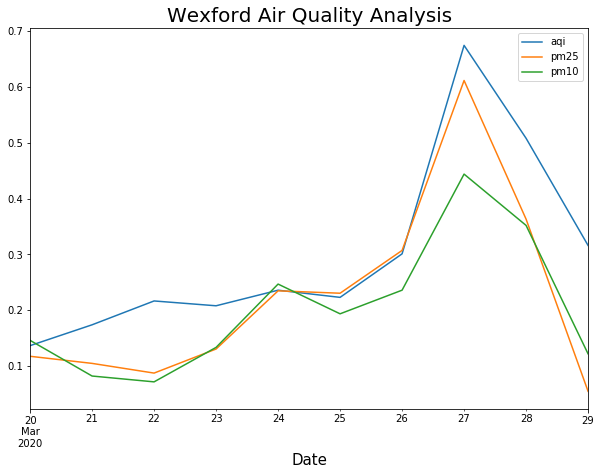

<Figure size 720x504 with 0 Axes>

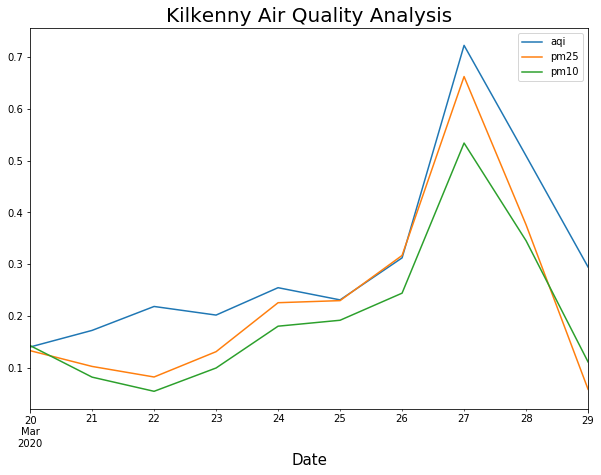

<Figure size 720x504 with 0 Axes>

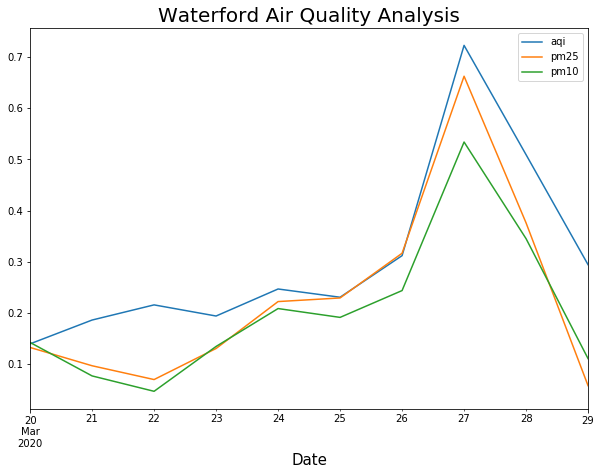

In [35]:
for key in county_lat_long_dict.keys():
   dataframe = req_data.loc[req_data.county_name==key]
   req_dataFrame = dataframe[['aqi','pm25','pm10','timestamp_utc']]
   req_dataFrame = req_dataFrame.set_index('timestamp_utc').groupby(pd.Grouper(freq='D')).mean()
   plt.figure(figsize=(10,7))
   req_dataFrame.plot(figsize=(10,7))
   plt.title(key+" Air Quality Analysis",fontsize=20)
   plt.xlabel("Date",fontsize=15)

### Task 6: Summarisation: 

From the above statistical analysis and visualisations, we see that Air Qualtiy Index(AQI) is strongly affected by pm25 and pm10. Since the data is limited further analysis needs to be carried out by incoperating other factors that might affect affect the AQI with a larger set of data.